In [52]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt

In multi-class classification problems, we have **two options** to **encode** the true **labels**  by using either:

* integer numbers, or
* one-hot vector

We will experiment with both encodings to observe the effect of the combinations of various last layer's activation functions and loss functions on a Keras CNN model's performance.


In both experiments, we will discuss the relationship between
 ***Activation & Loss functions***,  ***label encodings***, and **accuracy metrics** in details.

## Load a Multi-Class Dataset
I pick the MNIST dataset a famous multi class dataset

First let's load the MNIST dataset from [Tensorflow Datasets](https://www.tensorflow.org/datasets)

In [53]:
[ds_raw_train, ds_raw_test], info = tfds.load('mnist', 
                                      split=['train[:10%]','test[:10%]'], as_supervised=True, with_info=True)

In [54]:
print("Number of samples in train : ", ds_raw_train.cardinality().numpy(),
      " in test : ",ds_raw_test.cardinality().numpy())

Number of samples in train :  6000  in test :  1000


9 samples from the dataset


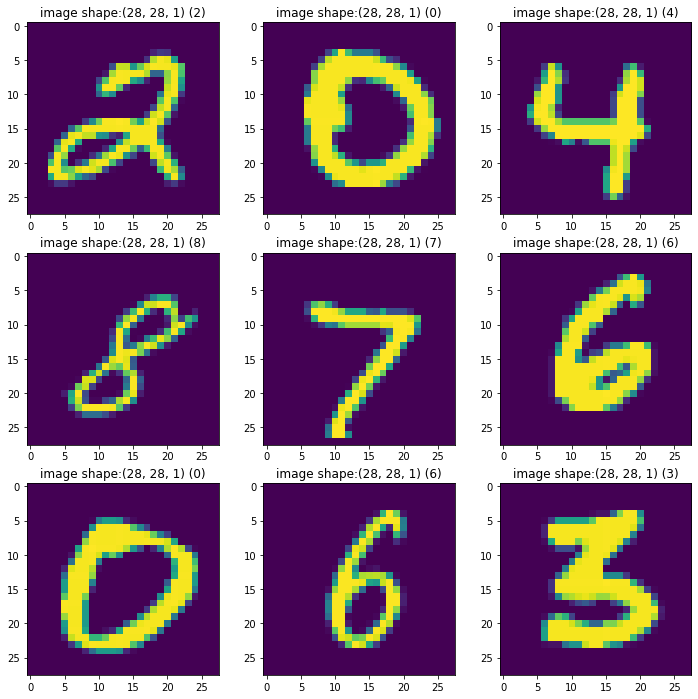

In [55]:
def show_samples(dataset):
  fig=plt.figure(figsize=(12, 12))
  columns = 3
  rows = 3
  
  print(columns*rows,"samples from the dataset")
  i=1
  for a,b in dataset.take(columns*rows): 
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(a))
    #plt.imshow(a.numpy())
    plt.title("image shape:"+ str(a.shape)+" ("+str(b.numpy()) +")" )

    i=i+1
  plt.show()
show_samples(ds_raw_test)

Notice that:**
* There are **10 classes** 
* For each sample, there is a **single integer value per class** 

### Let's resize and scale the images so that we can save time in training

In [56]:
#VGG16 expects min 32 x 32 
def resize_scale_image(image, label):
  image = tf.image.resize(image, [32, 32])
  image = image/255.0
  image = tf.image.grayscale_to_rgb(image)
  return image, label

9 samples from the dataset


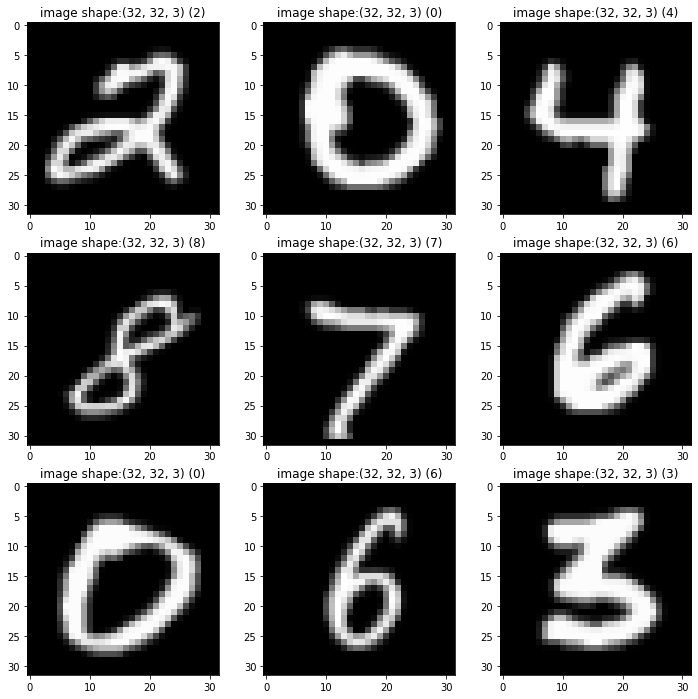

In [57]:
ds_train_resize_scale=ds_raw_train.map(resize_scale_image)
ds_test_resize_scale=ds_raw_test.map(resize_scale_image)
show_samples(ds_test_resize_scale)

9 samples from the dataset


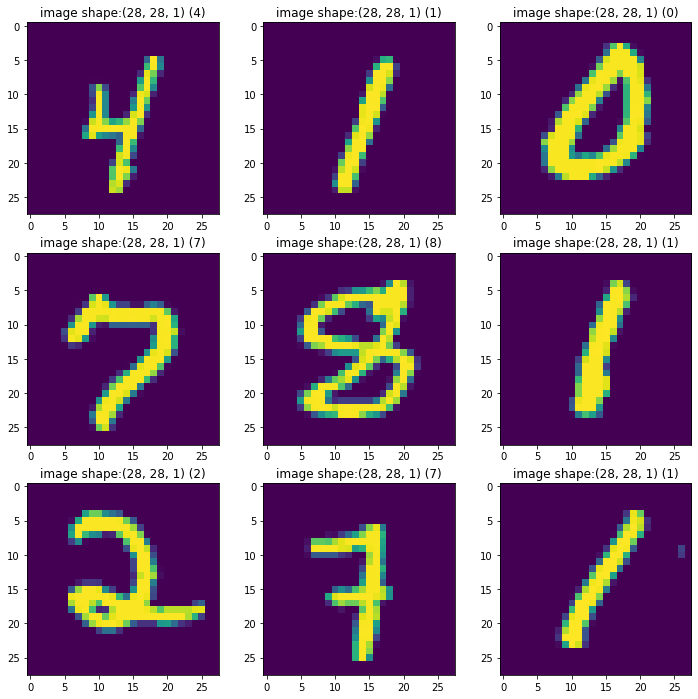

In [58]:
show_samples(ds_raw_train)

### Prepare the data pipeline by setting batch size & buffer size using [tf.data](https://www.tensorflow.org/guide/data)

In [59]:
batch_size = 64 

ds_train_resize_scale_batched=ds_train_resize_scale.batch(batch_size, drop_remainder=True ).cache().prefetch(tf.data.experimental.AUTOTUNE)
ds_test_resize_scale_batched=ds_test_resize_scale.batch(batch_size, drop_remainder=True ).cache().prefetch(tf.data.experimental.AUTOTUNE)

print("Number of batches in train: ", ds_train_resize_scale_batched.cardinality().numpy())
print("Number of batches in test: ", ds_test_resize_scale_batched.cardinality().numpy())


Number of batches in train:  93
Number of batches in test:  15


### To train fast, let's use Transfer Learning by importing VGG16

In [60]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(32, 32, 3), # VGG16 expects min 32 x 32
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

## 1. True (Actual) Labels are encoded with a **single integer number** 

### Create the classification model


In [61]:
number_of_classes = 10

In [62]:
inputs = keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation =  None  # tf.keras.activations.sigmoid or softmax

outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(x) 
model = keras.Model(inputs, outputs)

**Pay attention**:
* The last layer has 10 (***number_of_classes***) unit. So the output (***y_pred***)  will be **10 floating points** as the true (actual) label (***y_true***) is **a single integer number**!

* For the last layer, the activation function can be:
  * None 
  * sigmoid 
  * softmax
* When there is **no activation** function is used in the model's last layer, we need to set `from_logits=True` **in cross-entropy loss functions** as we discussed above. Thus, **cross-entropy loss functions** will apply a **sigmoid** transformation on **predicted label values**:

  `if from_logits: return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)`


In [63]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

**IMPORTANT:** We need to use **keras.metrics.SparseCategoricalAccuracy()** for **measuring** **the** **accuracy** since it calculates how often predictions match **integer labels**.


* As we mentioned above, Keras does ***not*** define a ***single*** accuracy metric, but ***several*** different ones, among them: `accuracy`, `binary_accuracy` and `categorical_accuracy`. 
* What happens under the hood is that, if you select ***mistakenly*** **categorical cross entropy as your loss function** in a **binary classification** and if you do ***not specify*** a particular accuracy metric by just writing
 
 `metrics="Accuracy"`

  Keras (***wrongly***...) **infers** that you are interested in the **categorical_accuracy**, and this is what it returns - while in fact you are interested in the **binary_accuracy** since our problem is a binary classification.

In summary; 
* to get `model.fit()` and `model.evaulate()` run correctly (without mixing the loss function and the classification problem at hand) we need to **specify the actual accuracy metric**!
* if the true (actual) labels are encoded with integer numbers, you need to use **keras.metrics.SparseCategoricalAccuracy()** for **measuring** **the** **accuracy** since it calculates how often how often predictions match **integer labels**.

In [64]:
model.fit(ds_train_resize_scale_batched, validation_data=ds_test_resize_scale_batched, epochs=40)

Epoch 1/40
93/93 [==============================] - 77s 804ms/step - loss: 1.7938 - sparse_categorical_accuracy: 0.5003 - val_loss: 1.3555 - val_sparse_categorical_accuracy: 0.6854
Epoch 2/40
93/93 [==============================] - 75s 803ms/step - loss: 1.1679 - sparse_categorical_accuracy: 0.7366 - val_loss: 0.9986 - val_sparse_categorical_accuracy: 0.7771
Epoch 3/40
93/93 [==============================] - 73s 785ms/step - loss: 0.9117 - sparse_categorical_accuracy: 0.7838 - val_loss: 0.8211 - val_sparse_categorical_accuracy: 0.8125
Epoch 4/40
93/93 [==============================] - 73s 788ms/step - loss: 0.7703 - sparse_categorical_accuracy: 0.8135 - val_loss: 0.7105 - val_sparse_categorical_accuracy: 0.8458
Epoch 5/40
93/93 [==============================] - 73s 785ms/step - loss: 0.6772 - sparse_categorical_accuracy: 0.8345 - val_loss: 0.6325 - val_sparse_categorical_accuracy: 0.8667
Epoch 6/40
93/93 [==============================] - 73s 787ms/step - loss: 0.6096 - sparse_cate

In [65]:
ds= ds_test_resize_scale
print("Test Accuracy: ", model.evaluate(ds.batch(batch_size=10))[1])
predictions= model.predict(ds.batch(batch_size=10).take(1))
y=[]
print("10 Sample predictions:")
for (pred,(a,b)) in zip(predictions,ds.take(10)):
  print("predicted: " , np.argmax(pred), "Actual Label: "+ str(b.numpy()) + " True" if (np.argmax(pred)==b.numpy()) else " False" )
  y.append(b.numpy())

100/100 [==============================] - 13s 124ms/step - loss: 0.2053 - sparse_categorical_accuracy: 0.9460
Test Accuracy:  0.9459999799728394
10 Sample predictions:
predicted:  2 Actual Label: 2 True
predicted:  0 Actual Label: 0 True
predicted:  4 Actual Label: 4 True
predicted:  8 Actual Label: 8 True
predicted:  7 Actual Label: 7 True
predicted:  6 Actual Label: 6 True
predicted:  0 Actual Label: 0 True
predicted:  6 Actual Label: 6 True
predicted:  3 Actual Label: 3 True
predicted:  1 Actual Label: 1 True


[2, 0, 4, 8, 7, 6, 0, 6, 3, 1]


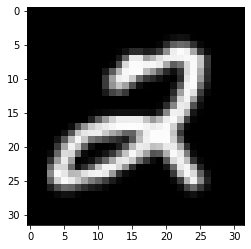

In [66]:
ds= ds_test_resize_scale
al=[]
bl=[]
for a,b in ds.take(10):
  al.append(a)
  bl.append(b.numpy())
print(bl)
#print(al[0])
plt.imshow(al[0])
plt.show()


* Generally, we use **softmax activation** instead of **sigmoid** with the **cross-entropy loss** because softmax activation distributes the probability throughout each output node (class).
* For **multi-class classification**, **softmax** is more recommended  rather than **sigmoid**. 
* The practical reason is that 
  * **softmax** is specially designed for **multi-class** classification tasks.
  * **Sigmoid** is equivalent to a 2-element **Softmax**, where the second element is assumed to be zero. Therefore, **sigmoid** is mostly used for **binary classification** and **multi-label classification**.

Let's see a simple example:

In [67]:
# Assume last layer output is as:
y_pred_logit = tf.constant([[-20, -1.0, 4.5, 12.5, 74, 43.2, -58.4, 8.2, 99.9, -101]], dtype = tf.float32)
print("y_pred_logit:\n", y_pred_logit.numpy())

# and last layer activation function is softmax:
y_pred_softmax = tf.keras.activations.softmax(y_pred_logit)
print("\nsoftmax(y_pred) :\n", y_pred_softmax.numpy())

# and last layer activation function is sigmoid:
y_pred_sigmoid = tf.keras.activations.sigmoid(y_pred_logit)
print("\nsigmoid(y_pred) :\n", y_pred_sigmoid.numpy())

y_pred_logit:
 [[ -20.    -1.     4.5   12.5   74.    43.2  -58.4    8.2   99.9 -101. ]]

softmax(y_pred) :
 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.6464083e-12
  2.3741193e-25 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]]

sigmoid(y_pred) :
 [[2.0611537e-09 2.6894143e-01 9.8901308e-01 9.9999630e-01 1.0000000e+00
  1.0000000e+00 4.3371215e-26 9.9972546e-01 1.0000000e+00 0.0000000e+00]]


As seen above, when the last layer generates some logits, s***igmoid and softmax functions produce different results***.

However, when we apply **sparse categorical_crossentropy** loss function on their results, ***the computed loss is exactly the same***:

In [68]:
y_true=[[5]]
y_pred = y_pred_sigmoid
print("\ny_true {} \n\ny_pred by sigmoid {}\n".format(y_true, y_pred))
print("categorical_crossentropy loss: ", tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred).numpy())


y_pred = y_pred_softmax
print("\ny_true {} \n\ny_pred by softmax {}\n".format(y_true, y_pred))
print("categorical_crossentropy loss: ", tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred).numpy())


y_true [[5]] 

y_pred by sigmoid [[2.0611537e-09 2.6894143e-01 9.8901308e-01 9.9999630e-01 1.0000000e+00
  1.0000000e+00 4.3371215e-26 9.9972546e-01 1.0000000e+00 0.0000000e+00]]

categorical_crossentropy loss:  [56.7]

y_true [[5]] 

y_pred by softmax [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.6464083e-12
  2.3741193e-25 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]]

categorical_crossentropy loss:  [56.7]


Notice that if we **do not apply any Activation** function at the last layer, we need to ***inform*** the cross entropy loss functions by setting the parameter ***from_logits=True*** so that the cross entropy loss functions will **apply a sigmoid** transformation onto the given **logits** by themselves!

---
## **In summary:**

We can **conclude** that, if the task is **multi-class classification** and true (actual) labels are encoded as a **single integer number** we have 2 options to go:
  * Option 1: 
  
  activation = **sigmoid** or **softmax** 

  loss =**SparseCategoricalCrossentropy()** 
  
  accuracy metric= **SparseCategoricalAccuracy()**
  * Option 2: 
  
  activation = **None**  
  
  loss =**SparseCategoricalCrossentropy(from_logits=True)** 
  
  accuracy metric= **SparseCategoricalAccuracy()**

## 2. True (Actual) Labels are one-hot encoded 

In multi-class classification problems, we can also use **one-hot encoding** for **target (y_true)** values. 
Now, let's **which activation, loss, and accuracy** functions we need to select when true classes are encoded one hot.

### First convert the true (actual) label encoding to one-hot

In [69]:
def one_hot(image, label):
  label = tf.one_hot(label, depth=number_of_classes)
  return image, label

9 samples from the dataset


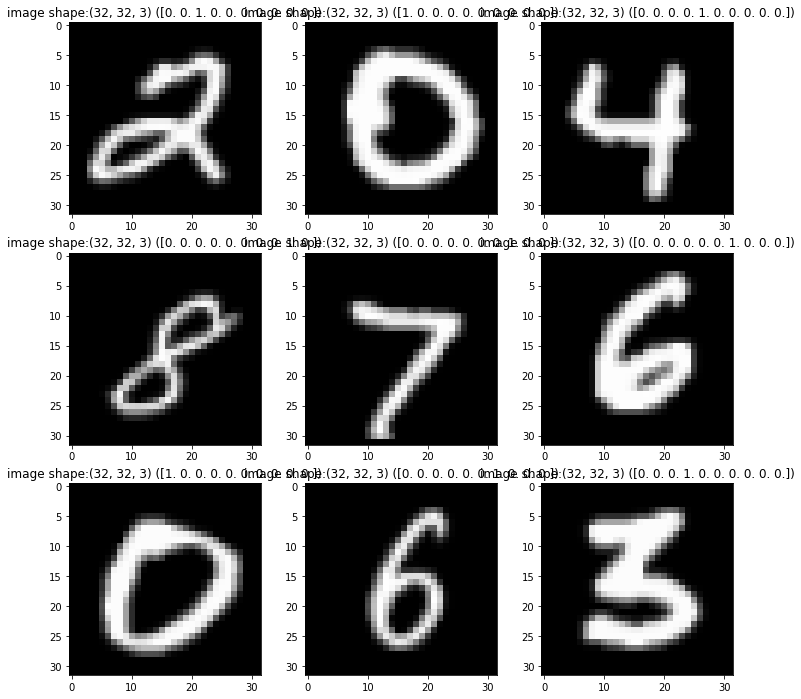

In [70]:
ds_train_resize_scale_one_hot= ds_train_resize_scale.map(one_hot)
ds_test_resize_scale_one_hot= ds_test_resize_scale.map(one_hot)
show_samples(ds_test_resize_scale_one_hot)

**Notice that:**
* There are **10 labels / classes** 
* Labels are now **one-hot encoded** 


### Prepare the data pipeline by setting batch size

In [71]:
ds_train_resize_scale_one_hot_batched=ds_train_resize_scale_one_hot.batch(64)
ds_test_resize_scale_one_hot_batched=ds_test_resize_scale_one_hot.batch(64)

In [72]:
# Create the classification model

inputs = keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

initializer = tf.keras.initializers.GlorotUniform(seed=42)
activation = tf.keras.activations.softmax # None  #  tf.keras.activations.sigmoid or softmax

outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(x) 
 
model = keras.Model(inputs, outputs)

**Pay attention**:
* The last layer has **number_of_classes (10) units**. Thus the output will support  **one-hot** encoding of the true (actual) label. 

* For the last layer, the activation function can be:
  * None 
  * sigmoid 
  * softmax
* When there is **no activation** function is used, we need to set `from_logits=True` **in cross-entropy functions** as we discussed above

In [73]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(), # default from_logits=False
              metrics=[keras.metrics.CategoricalAccuracy()])

In [74]:
model.fit(ds_train_resize_scale_one_hot_batched, validation_data=ds_test_resize_scale_one_hot_batched, epochs=20)

Epoch 1/20
94/94 [==============================] - 75s 796ms/step - loss: 1.7628 - categorical_accuracy: 0.5182 - val_loss: 1.3277 - val_categorical_accuracy: 0.7250
Epoch 2/20
94/94 [==============================] - 74s 792ms/step - loss: 1.1465 - categorical_accuracy: 0.7487 - val_loss: 0.9822 - val_categorical_accuracy: 0.7900
Epoch 3/20
94/94 [==============================] - 74s 786ms/step - loss: 0.8977 - categorical_accuracy: 0.7913 - val_loss: 0.8097 - val_categorical_accuracy: 0.8250
Epoch 4/20
94/94 [==============================] - 74s 786ms/step - loss: 0.7600 - categorical_accuracy: 0.8175 - val_loss: 0.7020 - val_categorical_accuracy: 0.8370
Epoch 5/20
94/94 [==============================] - 74s 787ms/step - loss: 0.6692 - categorical_accuracy: 0.8362 - val_loss: 0.6261 - val_categorical_accuracy: 0.8580
Epoch 6/20
94/94 [==============================] - 74s 785ms/step - loss: 0.6031 - categorical_accuracy: 0.8498 - val_loss: 0.5686 - val_categorical_accuracy: 0.873

In [75]:
ds= ds_test_resize_scale_one_hot
print("Test Accuracy: ", model.evaluate(ds.batch(batch_size=10))[1])
print("10 Sample predictions ")
predictions= model.predict(ds.batch(batch_size=10).take(1))
y=[]
for (pred,(a,b)) in zip(predictions,ds.take(10)):
  print("predicted: " , (pred), "Actual Label: "+str(b.numpy()) , " True" if (np.argmax(pred)==np.argmax(b.numpy())) else " False" )
  print()
  y.append(b.numpy())

100/100 [==============================] - 13s 125ms/step - loss: 0.2918 - categorical_accuracy: 0.9290
Test Accuracy:  0.9290000200271606
10 Sample predictions 
predicted:  [1.6424896e-03 2.8560635e-05 7.7272516e-01 2.8965754e-02 4.6789438e-02
 5.2497245e-02 2.0528310e-03 5.7823155e-03 7.2134398e-02 1.7381839e-02] Actual Label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]  True

predicted:  [9.8883039e-01 9.5161550e-07 3.8861978e-04 1.6135331e-05 6.7486376e-06
 4.5802566e-04 4.1635064e-03 3.2108801e-05 4.0310217e-04 5.7004471e-03] Actual Label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  True

predicted:  [2.0709206e-04 2.2101820e-04 3.7569348e-03 1.3936593e-03 9.7488564e-01
 3.0296349e-03 6.3087360e-04 9.4148917e-03 4.4972468e-03 1.9630967e-03] Actual Label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  True

predicted:  [2.3144871e-04 3.1321983e-05 1.3991864e-01 8.7674316e-03 1.2030722e-02
 1.3890222e-02 6.4668660e-03 4.3128434e-04 7.5417805e-01 6.4054012e-02] Actual Label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]  True

predic

According to the above experiment results, if the task is **multi-class classification** and true (actual) labels are encoded as a **one-hot**, we might have 2 options:
* Option A
  * activation = **None**
  * loss = **CategoricalCrossentropy(from_logits=True)**
  * accuracy metric= **CategoricalAccuracy()**
* Option B
  * activation = **sigmoid or softmax** 
  * loss =**CategoricalCrossentropy()** 
  * accuracy metric= **CategoricalAccuracy()**


In a nut shel, in a **multi-class** classification 
* We can use **integer numbers** or **one-hot encoding** to encode the **true** classes / labels 
*  ***The correct accuracy metric*** depends on **the selected true label encoding**
* Last layer activation function could be **Sigmoid, Softmax or None**
* ***The correct loss function*** should be decided according to **the selected true label encoding**

So the summary of the experiments are below:

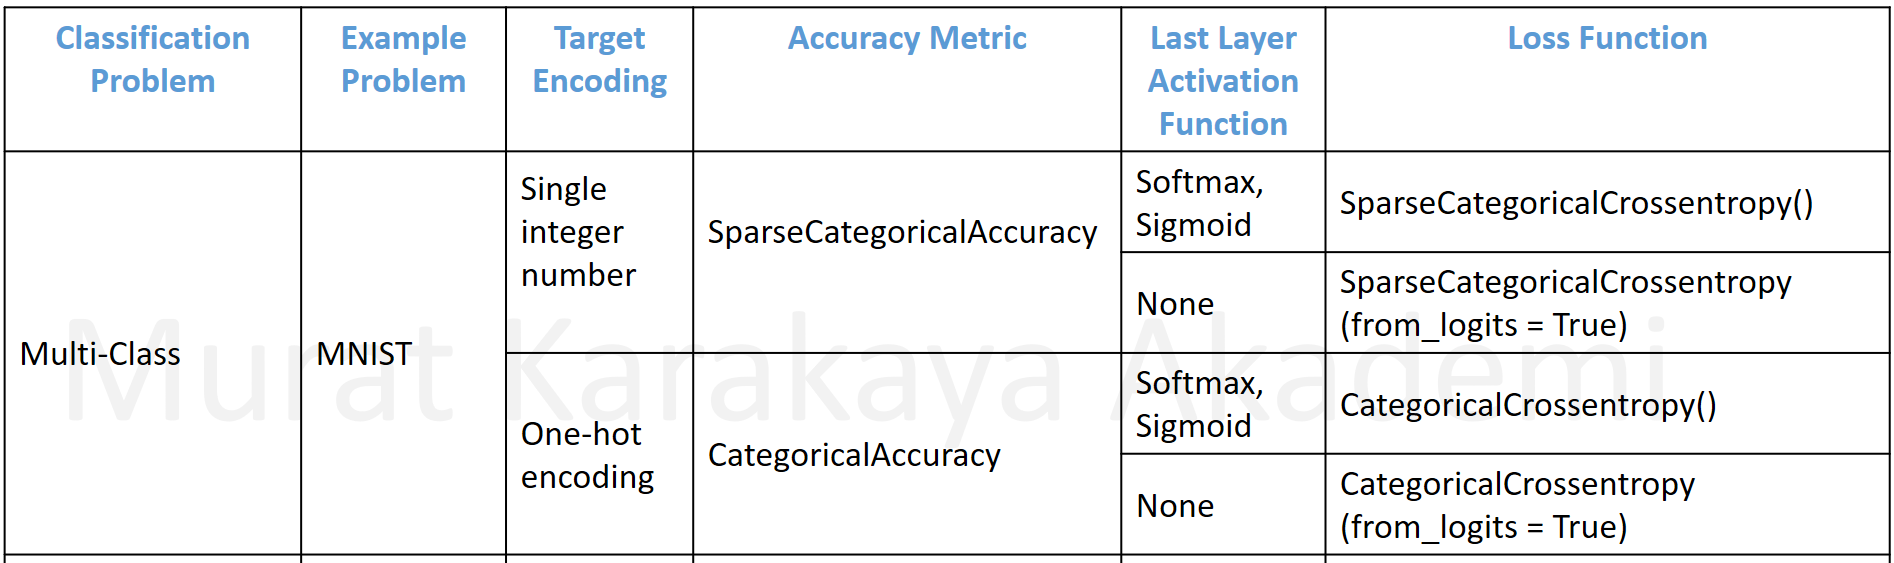